#Import Library

In [16]:
#Import library
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Prepocesing data


In [17]:
df = pd.read_csv('raw_sales.csv')
df.head(200)

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3
...,...,...,...,...,...
195,2008-05-02 00:00:00,2906,332000,house,2
196,2008-05-02 00:00:00,2906,622500,house,4
197,2008-05-02 00:00:00,2602,775000,house,4
198,2008-05-05 00:00:00,2604,575000,house,2


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datesold      29580 non-null  object
 1   postcode      29580 non-null  int64 
 2   price         29580 non-null  int64 
 3   propertyType  29580 non-null  object
 4   bedrooms      29580 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [19]:
df.isnull().sum()

datesold        0
postcode        0
price           0
propertyType    0
bedrooms        0
dtype: int64

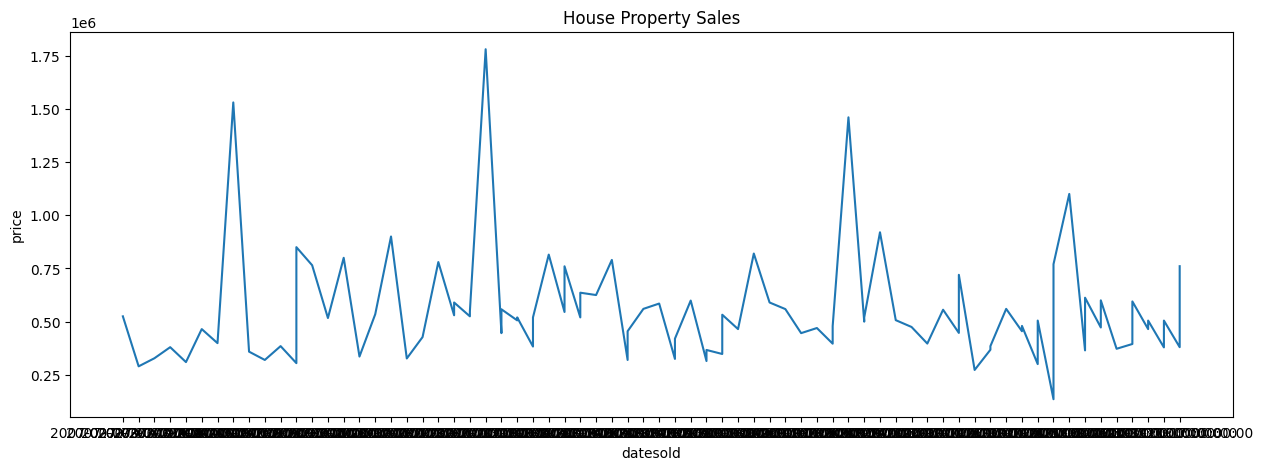

In [20]:
date = df['datesold'].values
price = df['price'].values


plt.figure(figsize=(15, 5))
plt.plot(date[:100], price[:100])
plt.title('House Property Sales')
plt.xlabel('datesold')
plt.ylabel('price')
plt.show()


In [21]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

train_x, val_x, train_y, val_y = train_test_split(date, price, test_size=0.2, shuffle=False)

# Ubah bentuk train_y menjadi array 2D
train_y = train_y.reshape(-1, 1)

# Inisialisasi dan fit scaler pada data pelatihan
scaler = MinMaxScaler()
scaler.fit(train_y)

# Transformasi data menggunakan scaler
train_set = windowed_dataset(scaler.transform(train_y), window_size=60, batch_size=100, shuffle_buffer=1000)

# Ubah bentuk val_y menjadi array 2D dan transformasi data uji
val_y = val_y.reshape(-1, 1)
val_set = windowed_dataset(scaler.transform(val_y), window_size=60, batch_size=100, shuffle_buffer=1000)

# Building Model


In [22]:

model = tf.keras.models.Sequential([
  # tf.keras.layers.LSTM(64)
  tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(None, 1)),
  # tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])


#looking value MAE
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-05, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

threshold_mae = (df['price'].max() - df['price'].min()) * 0.1
print('Mae: ', threshold_mae)


# callback
class stopCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if self.has_reached_accuracy(logs):
            print(' Stop training model, mae < 10% successfully')
            self.model.stop_training = True

    def has_reached_accuracy(self, logs):
        return (logs.get('mae') < 0.04  and  logs.get('val_mae') < 0.02)

callbacks = stopCallBack()
history = model.fit(train_set,
                    epochs=32,
                    validation_data = val_set,
                    callbacks = [callbacks],
                    verbose=2)

Mae:  794350.0
Epoch 1/32
237/237 - 33s - loss: 0.0032 - mae: 0.0712 - val_loss: 0.0014 - val_mae: 0.0458 - 33s/epoch - 138ms/step
Epoch 2/32
237/237 - 27s - loss: 0.0028 - mae: 0.0660 - val_loss: 0.0012 - val_mae: 0.0408 - 27s/epoch - 114ms/step
Epoch 3/32
237/237 - 29s - loss: 0.0025 - mae: 0.0612 - val_loss: 0.0010 - val_mae: 0.0364 - 29s/epoch - 124ms/step
Epoch 4/32
237/237 - 29s - loss: 0.0022 - mae: 0.0568 - val_loss: 8.6607e-04 - val_mae: 0.0325 - 29s/epoch - 123ms/step
Epoch 5/32
237/237 - 32s - loss: 0.0020 - mae: 0.0528 - val_loss: 7.5610e-04 - val_mae: 0.0291 - 32s/epoch - 134ms/step
Epoch 6/32
237/237 - 29s - loss: 0.0018 - mae: 0.0492 - val_loss: 6.6788e-04 - val_mae: 0.0262 - 29s/epoch - 123ms/step
Epoch 7/32
237/237 - 27s - loss: 0.0017 - mae: 0.0459 - val_loss: 5.9630e-04 - val_mae: 0.0237 - 27s/epoch - 114ms/step
Epoch 8/32
237/237 - 28s - loss: 0.0016 - mae: 0.0429 - val_loss: 5.3800e-04 - val_mae: 0.0217 - 28s/epoch - 117ms/step
Epoch 9/32
237/237 - 28s - loss: 0.00

In [23]:
print(history.history)


{'loss': [0.0031690632458776236, 0.0028157683555036783, 0.002508732955902815, 0.002247440628707409, 0.0020299579482525587, 0.0018465945031493902, 0.0016904554795473814, 0.001557579031214118, 0.0014441185630857944, 0.0013461550697684288], 'mae': [0.07119069248437881, 0.06603532284498215, 0.06120005622506142, 0.05676351860165596, 0.052787862718105316, 0.04919363558292389, 0.04591380059719086, 0.04293425381183624, 0.040229760110378265, 0.03776220604777336], 'val_loss': [0.001391032012179494, 0.0011757033644244075, 0.0010035719024017453, 0.0008660650346428156, 0.0007561024976894259, 0.0006678758654743433, 0.0005962967406958342, 0.0005380003713071346, 0.0004906253307126462, 0.0004519824287854135], 'val_mae': [0.04578680172562599, 0.04082682356238365, 0.0364094041287899, 0.03251846879720688, 0.029105864465236664, 0.026173144578933716, 0.023717191070318222, 0.021727338433265686, 0.020156076177954674, 0.01894727535545826]}


In [24]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


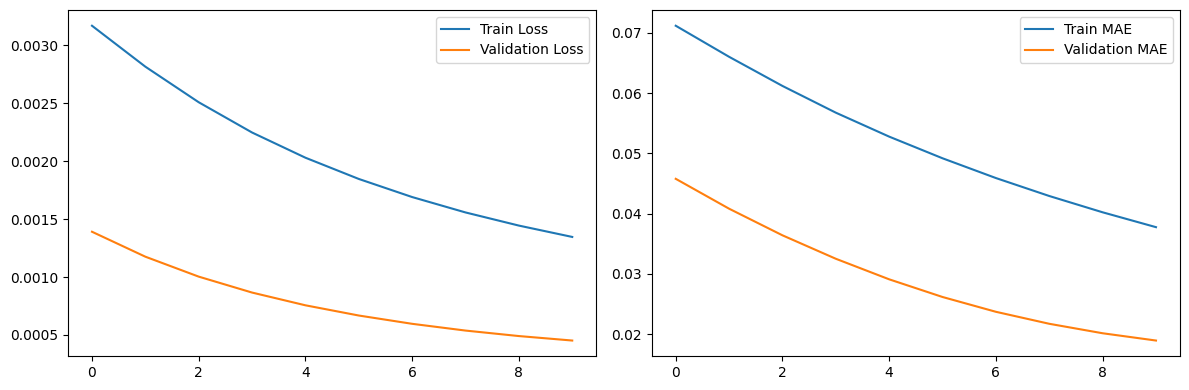

In [25]:

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()